# Deep Learning for Computer Vision

---

**Goethe University Frankfurt am Main**

Winter Semester 2022/23

<br>

## *Assignment 8 (Multimodal Learning)*

---

**Points:** 40<br>
**Due:** 9.2.2022, 10 am<br>
**Contact:** Timothy Schaumlöffel (Discord)<br>

---

**Your Name:** Tilo-Lars Flasche

<br>

# 1. Multimodal Fusion

---
In this task we want to investigate to what extent different modalities can help in solving a problem. For this we will use the [MuMu](https://arxiv.org/pdf/1707.04916.pdf) dataset, which specifies the **genre of music albums**. We focus on the two modalities audio and vision. To reduce complexity, these are provided as vectors already embedded by a unimodal encoder.

For the audio data, a CNN was trained on the spectrograms of the individual tracks and the average was taken for the whole album. The visual part of an album corresponds to the cover image. It was embedded using a ResNet101.

A single album can have multiple genres, so this becomes a multi-label classification problem. Moreover, these genres are very unbalanced, as you can see in the figure below. The number of classes has been reduced to 20 for this assignment.

<br>

<center><img src="assets/top20_genre.png" width=1024 height=400/></center>

<br>

We trained a simple classification head on top of the uni-modal features. Since it's a multi-label problem we used binary cross entropy loss and evaluate with mean average precision. The results are as follows:

$$
    \text{mAP}_{audio} = 0.560 \\
    \text{mAP}_{vision} = 0.292
$$

During the exercise we will try to improve these results by combining modalities.

In [1]:
!pip install torchmetrics

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from multimodal.solver import Solver, show_training
from multimodal.dataset import AlbumGenreDataset

Download the prepared dataset from [here](https://www.dropbox.com/s/iz54mea432vg8o1/album_genre_dataset.zip?dl=0) and decompress to the project directory (or to any location but change the `root` value in the follownig cell).

The dataset is loaded by the `AlbumGenreDataset` class. It returns a tuple `(audio_features, visual_features)` of normalized features and the one-hot encoded ground-truth genres. If you run the following cell you can the output format.

In [3]:
root = 'album_genre_dataset'
num_classes = 20
num_epochs = 10

train_ds = AlbumGenreDataset(root, 'train')
val_ds = AlbumGenreDataset(root, 'val')

x, y = train_ds[0]
print(f"Audio features shape : {x[0].shape}")
print(f"Visual features shape: {x[1].shape}")
print(f"Target shape         : {y.shape}")
print(f"Target: {y}")

Audio features shape : (4096,)
Visual features shape: (2048,)
Target shape         : (20,)
Target: [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Task 1.1: Fusion (8 Points)

Create a simple model that expects visual and auditory embeddings, concatenates them and forwards them through a MLP for the final prediction. Use the provided `Solver` to train the model. The training loop is already implemented and configured for you. The loss function is `BCEWithLogitsLoss`, so you don't have to apply any activation one the prediction. For evaluation, we use the `torchmetrics` module.

In [4]:
############################################################
##                   START OF YOUR CODE                   ##
############################################################

class MultiModalClassifier(nn.Module):
    def __init__(self, visual_embedding_size, auditory_embedding_size, num_classes):
        super().__init__()
        # Hyperparameters
        self.visual_embedding_size = visual_embedding_size
        self.auditory_embedding_size = auditory_embedding_size
        self.num_classes = num_classes
        
        # Layers
        self.fc = nn.Linear(visual_embedding_size + auditory_embedding_size, num_classes)

    def forward(self, input):
        # Concatenate visual and auditory features
        embeddings = torch.cat(input, dim=1)
        # Classify the embedded vector
        out = self.fc(embeddings)
        
        return out

############################################################
##                   END OF YOUR CODE                     ##
############################################################

C:\Users\tilof\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)



Best mAP: 0.592


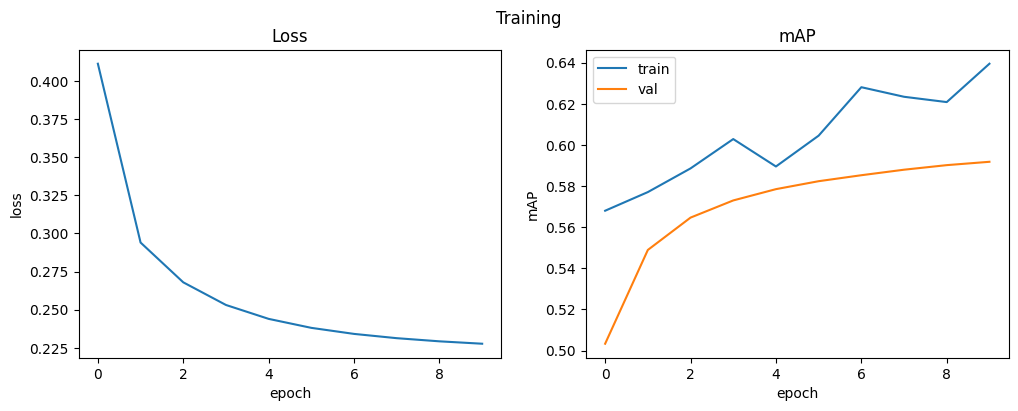

In [5]:
model = MultiModalClassifier(2048, 4096, 20)  # initialize your module

solver = Solver(
    model=model,
    data={
        'train': train_ds,
        'val': val_ds
    },
    loss='BCEWithLogitsLoss',
    loss_config={},
    optimizer='Adam',
    optimizer_config={'lr': 1e-4},
    batch_size=32,
    metric='AveragePrecision', # see torchmetrics.AveragePrecision for details
    metric_config={'num_labels': num_classes, 'task': 'multilabel'},
)

hist = solver.train(num_epochs=num_epochs)
print(f"Best mAP: {max(hist['val_acc']):.3f}")
show_training(hist)

## Task 1.2: Gated Fusion (12 Points)

Implement a model that fused both modalities using a [Gated Multimodal Unit](https://arxiv.org/pdf/1702.01992.pdf). After fusion, forward the resul through a simple MLP for prediction.

In [6]:
############################################################
##                   START OF YOUR CODE                   ##
############################################################

class GMU(nn.Module):
    def __init__(self, visual_embedding_size, auditory_embedding_size, hidden_size, num_classes):
        super().__init__()
        
        # Hyperparameters
        self.visual_embedding_size = visual_embedding_size
        self.auditory_embedding_size = auditory_embedding_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        
        # Layers
        
        # Visual Gate
        self.fc_xv = nn.Linear(visual_embedding_size, hidden_size, bias=False)
        self.activation_xv = nn.Tanh()
        
        # Auditory Gate
        self.fc_xa= nn.Linear(auditory_embedding_size, hidden_size, bias=False)
        self.activation_xa = nn.Tanh()
        
        # Z-Gate
        self.fc_gate = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.activation_gate = nn.Sigmoid()

        # Classification Layer
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, input):
        # Extract xt and xv
        xa, xv = input
        
        # Run xv, xa and z through the gates and compute hv, ht and z
        hv = self.activation_xv(self.fc_xv(xv))
        ha = self.activation_xa(self.fc_xa(xa))
        z = self.activation_gate(self.fc_gate(torch.cat([ha, hv], axis=1)))

        # Compute h
        h = z * hv + (1.0 - z) * ha

        # Classify h
        out = self.fc(h)

        return out

############################################################
##                   END OF YOUR CODE                     ##
############################################################


Best mAP: 0.615


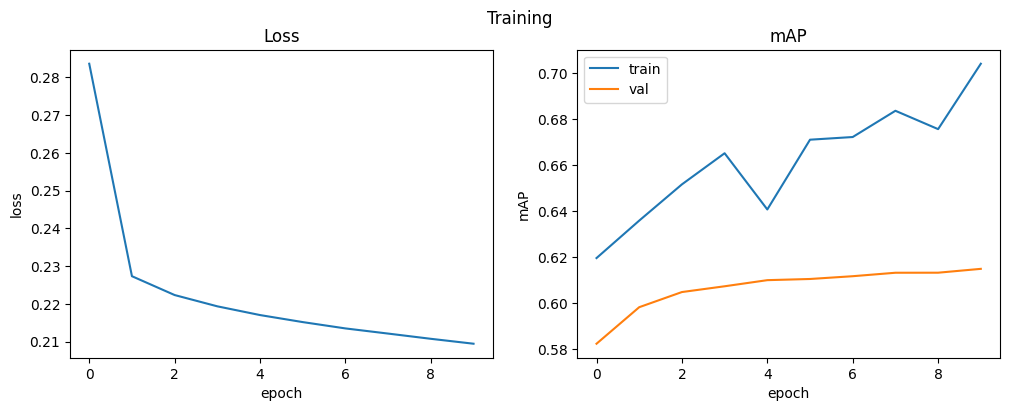

In [7]:
model = GMU(2048, 4096, 1500, 20)

solver = Solver(
    model=model,
    data={
        'train': train_ds,
        'val': val_ds
    },
    loss='BCEWithLogitsLoss',
    loss_config={},
    optimizer='Adam',
    optimizer_config={'lr': 1e-4},
    batch_size=32,
    metric='AveragePrecision',
    metric_config={'num_labels': num_classes, 'task': 'multilabel'},
)

hist = solver.train(num_epochs=num_epochs)
print(f"Best mAP: {max(hist['val_acc']):.3f}")
show_training(hist)

## Task 1.3 (Optional)
Can you get even better? Feel free to experiment with other fusion techniques.

# 2. CLIP: Zero-Shot Evaluation

---
The [CLIP](https://arxiv.org/abs/2103.00020) model is pre-trained on a large set of image-caption pairs using a contrastive loss. For this, the images and the text are embedded by two separate encoders and compared with the cosine similarity. Positive image-text pairs should be more similar than negative pairs in the representation space.

This allows an evaluation using zero-shot classification, which we will perform in the following using the CIFAR10 dataset. The idea is to classify the images without explicitly training the model on these classes. This is possible due to the capabilities of the text encoder to capture the classes and the coordinated representation space.

<br>

<center><img src="https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png" width=1024 height=512/></center>

<br>

You can see the concept of performing zero-shot classification on the right side of the figure. It is a two-stage process:
1. The text encoder is utilized to embed the class names. It is common to insert the class name into a prompt beforehand to provide more context to the model.
2. Embed the image with the image encoder and compare the resulting representations with all previously computed text embeddings. Use the cosine similarity to find the best matching class.

Let's start by installing the model from the official repository as well as some dependencies.

In [8]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ---------------------------------------- 53.1/53.1 kB 2.7 MB/s eta 0:00:00
     -------------------------------------- 267.7/267.7 kB 5.6 MB/s eta 0:00:00


  Cloning https://github.com/openai/CLIP.git to c:\users\tilof\appdata\local\temp\pip-req-build-y5nbi216
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369447 sha256=e66e29e86b8ad13aa87a20a5171c7d0db04c0071ce40794446879edfaab8579a
  Stored in directory: C:\Users\tilof\AppData\Local\Temp\pip-ephem-wheel-cache-7qxoz5xb\wheels\da\2b\4c\d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\tilof\AppData\Local\Temp\pip-req-build-y5nbi216'


In [15]:
import clip
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm

# The CPU should be sufficient for this task
device = 'cuda' if torch.cuda.is_available() else 'cpu'

CLIP was trained with different image encoders, which are listed below. Mainly different sized ResNets and visual transformers are used. Due to limitations in processing power, we'll use the ResNet50 (`RN50`).

In [16]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [17]:
# Load the model
model, preprocess = clip.load("RN50", device=device, download_root=None)
model.eval()

# This also provides a useful preprocessing pipeline for the images
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000001BA85BDC8B0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [18]:
# Class labels of CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load the test set of CIFAR10 and add the preprocessing pipeline
cifar10 = CIFAR10(root='./data', train=False, download=True, transform=preprocess)

# Create a dataloader
dl = DataLoader(cifar10, batch_size=64, num_workers=2, shuffle=False)

Files already downloaded and verified


## Cosine Similarity

Given two vectors a and b the cosine similarity is defined as:

$$
    cos(\mathbf{a}, \mathbf{b}) = \dfrac{\langle \mathbf{a}, \mathbf{b} \rangle}{||\mathbf{a}||\cdot ||\mathbf{b}||} = \dfrac{ \mathbf{a}^T\mathbf{b}}{||\mathbf{a}||\cdot ||\mathbf{b}||}
$$

This reduces to the standard inner product if your vectors are normalized to unit norm. We can take advantage of this to simplify the calculation of text and image similarity.


## 2.1 Task: Text Embedding (8 Points)
We start by embedding all class names using the text encoder. This can be achieved with the function `encode_text` of the CLIP model. The encoder expects text tokens from a [byte-pair encoding](https://huggingface.co/course/chapter6/5?fw=pt), that is implemented in `clip.tokenize`. It maps the raw stings to an int32 tensor. Follow these steps:

1. Insert each classname into the template to create a prompt
2. Tokenize the prompts with `clip.tokenize`
3. Forward the result through the text encoder
4. Normalize the embedding


In [33]:
############################################################
##                   START OF YOUR CODE                   ##
############################################################

# let's start by using no prompt but simply the classname as sanity check
template = 'In this image you can see a {}'

# The result is a tensor of shape (1024, 10),
# since we have 10 classes and the feature dimension of the text encoder is 1024
text_embedding = None


# we don't want to calculate gradient during evaluation
with torch.no_grad():
    text_embedding = []
    for classname in classes:
        # Parse template
        text = template.format(classname)
        # Text tokenization
        text = clip.tokenize(text).to(device)
        # Run tokens through the model and get embeddings
        text_embeddings = model.encode_text(text)
        # Result normalization
        text_embeddings = (text_embeddings - torch.mean(text_embeddings)) / torch.std(text_embeddings)
        text_embedding.append(text_embeddings.squeeze())

    # Reshape embeddings
    text_embedding = torch.stack(text_embedding, dim=1).to(device)

############################################################
##                    END OF YOUR CODE                    ##
############################################################

## 2.2 Task: Zero-Shot evaluation (8 Points)
Finally we can make a prediction by forwarding the images and compare them to the text embeddings.

1. Loop over the dataset
2. Create visual embeddings with the image encoder
3. Calculate the cosine similarity between the image and text embeddings
4. Count the number of correct predictions

The accuracy should be around `0.708` if no prompt was used.

In [34]:
############################################################
##                   START OF YOUR CODE                   ##
############################################################

correct = 0
total = len(cifar10)

with torch.no_grad():
    # Iterate over the dataset
    for i, (images, target) in enumerate(tqdm(dl)):
        # Get images and targets
        images = images.to(device)
        target = target.to(device)
        
        # Create visual embeddings
        image_features = model.encode_image(images)

        # Compute the cosine similarity between the image features and the text embeddings
        similarity = torch.matmul(image_features, text_embedding) / (image_features.norm() * text_embedding.norm())

        # Get the highest scores
        pred = similarity.topk(1)[1]

        # Compute correct rpedictions
        correct += (pred.squeeze() == target).sum(0)

print(f"Accuracy: {correct / total: .3f}")

############################################################
##                    END OF YOUR CODE                    ##
############################################################

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.75it/s]

Accuracy:  0.672


## 2.3 Task: Prompt tuning (4 Points)
Create a few other prompts and test the accuracy using the code from the previous tasks. You should increase the accuracy. Report you results.

# Your results:

| Prompt | Accuracy | Comment            |
|--------| --- |--------------------|
| '{}'  | 0.708 | Could be better... |
| 'A {}'  | 0.672 | Poor result |
| 'This image contains {}' | 71.5 | Improvment, but not significantly better |
| 'There is {}' | 71.5 | Improvment, but not significantly better |
| 'In this image you can see a {}' | 0.727 | Best result so far |
| 'You can see a {} in this image' | 0.727 | Best result so far |